In [1]:
from utils import *
import pickle
import pandas as pd
import os

from scipy.ndimage import gaussian_filter
from scipy.interpolate import RectBivariateSpline
from scipy.stats import gaussian_kde
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image

import numpy as np
from scipy.optimize import minimize, basinhopping

from collections import Counter
from tqdm.auto import tqdm


import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": False, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})
plt.rc("text", usetex=False)
plt.rc("font", family="serif")

## Testing

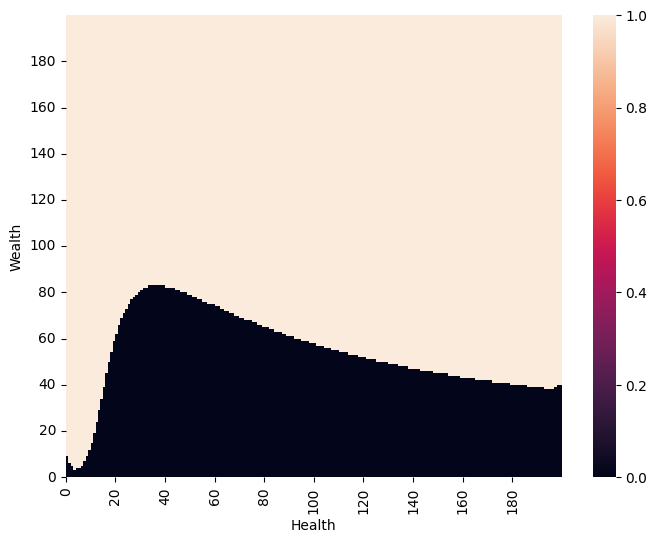

In [2]:
policy, params, _ = value_iteration(
    N=200,
    alpha=0.5567,
    gamma=0.6,
    theta=0.88,
    omega=2.25,
    eta=0.88,
    beta=0.95,
    P_H_increase=0.9,
    invest_cost=1,
    health_delta=3,
    health_decrease_scale=0.67
)

plot_policy_boundary(policy, params)

In [5]:
num_steps = 3000
num_agents = 10000

util, wealth, health = simulate(
    params,
    policy,
    num_steps,
    num_agents
)

# plot_utility_trajectories(util)

## Steady State

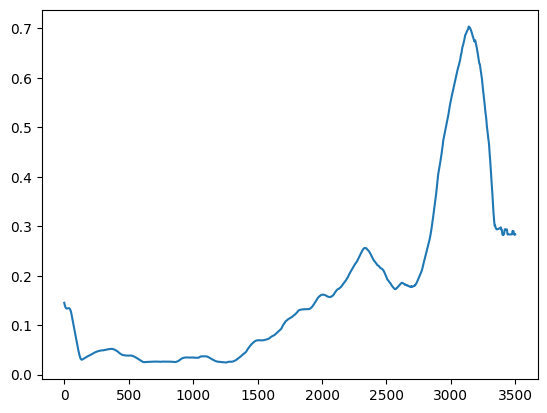

In [67]:
asdf = util[0,:]

cv = [np.std(asdf[i:i+500]) / np.mean(asdf[i:i+500]) for i in range(len(asdf)-500)]
plt.plot(cv)
plt.show()

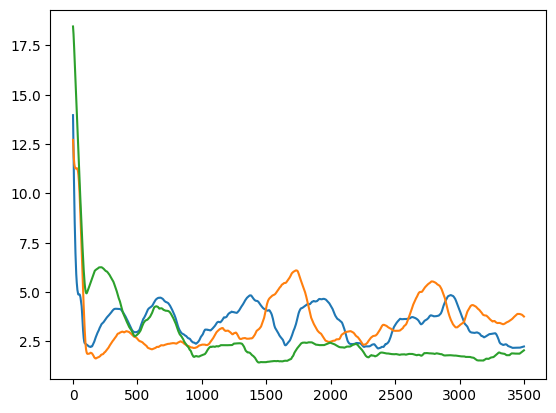

In [71]:
for i in range(6,9):
    
    asdf = util[i,:]

    cv = [np.std(asdf[i:i+500]) for i in range(len(asdf)-500)]
    plt.plot(cv)
plt.show()

## Results

In [51]:
# filepath = "results/0.5568190175603988_1_3_0.67.pickle"
# filepath = "results/0.22281696517478075_2_4_1.0.pickle"
filepath = "results/0.9609052284742076_1_1_1.0.pickle"

with open(filepath, "rb") as f:
    res = pickle.load(f)
wealth = res["wealth"]
health = res["health"]

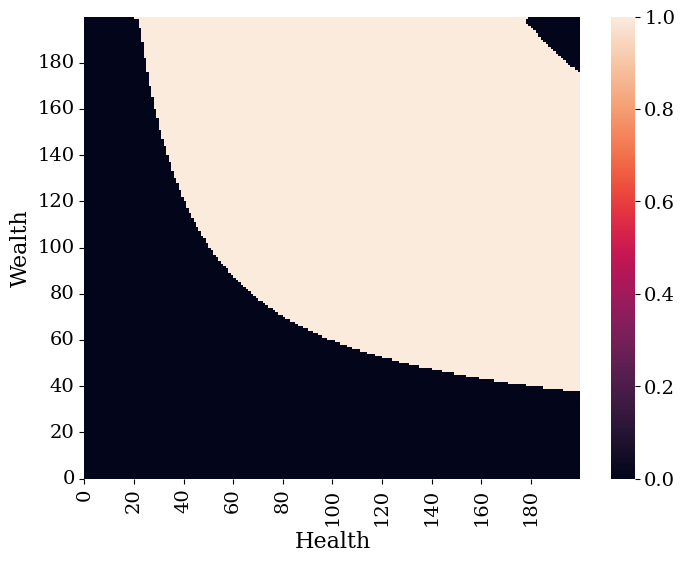

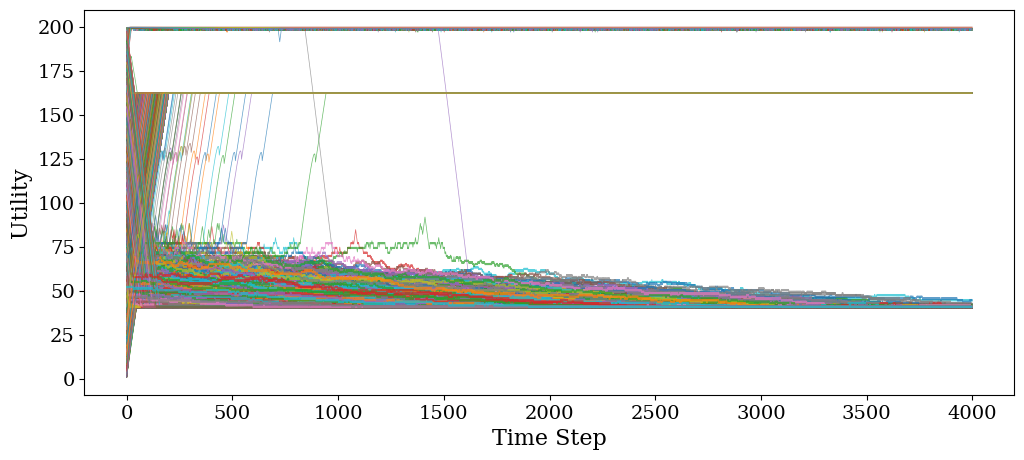

In [52]:
util = utility(res["wealth"], res["health"], alpha=res['params']['alpha'])
plot_policy_boundary(res["policy"], res["params"])
plot_utility_trajectories(util)

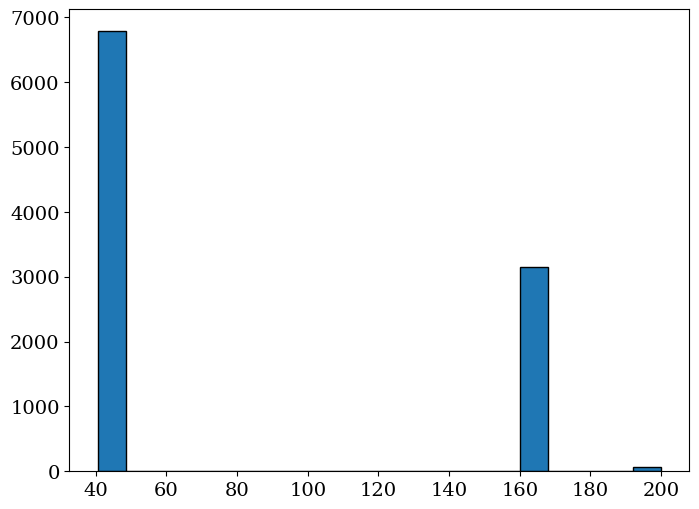

In [53]:
plt.hist(util[:,-1], bins=20, edgecolor='k')
plt.show()

## Density, Potential, Interpolation

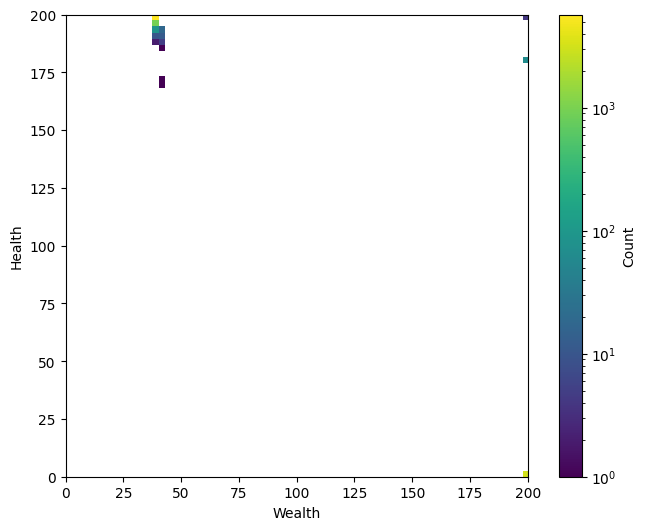

In [725]:
hist, xedges, yedges = np.histogram2d(wealth[:,-1], health[:,-1], bins=75, range=[(0,200), (0,200)])
plt.figure(figsize=(8, 6))
plt.imshow(hist.T, origin='lower', cmap='viridis', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], norm="log")
plt.colorbar(label='Count')
plt.xlabel('Wealth')
plt.ylabel('Health')
plt.show()

In [726]:
# compute density and potential
density = hist / np.sum(hist)
with np.errstate(divide='ignore'):
    potential = -np.log(density)
    potential[np.isinf(potential)] = np.nan

# interpolation function
max_finite_value = np.nanmax(potential)
potential[np.isnan(potential)] = max_finite_value + 1
smoothed_potential = gaussian_filter(potential, sigma=1)

interp_func = RectBivariateSpline(np.linspace(0,199,len(xedges)-1), np.linspace(0,199,len(xedges)-1), smoothed_potential)
INTERPOLATION = np.zeros((200,200))
for i,x in enumerate(np.linspace(0, 199, 200)):
    for j,y in enumerate(np.linspace(0, 199, 200)):
        potential_at_point = interp_func(x, y)[0, 0]
        INTERPOLATION[i][j] = potential_at_point

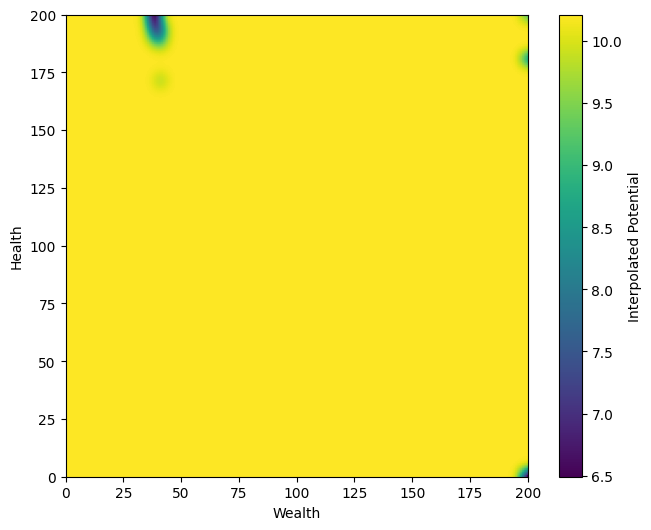

In [727]:
plt.figure(figsize=(8, 6))
plt.imshow(INTERPOLATION.T, origin='lower', cmap='viridis', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar(label='Interpolated Potential')
plt.xlabel('Wealth')
plt.ylabel('Health')
plt.show()

## Mean First Passage Time (MFPT)

In [585]:
def compute_MFPT(n_steps, n_simulations, start_pos, target_pos, step_size, interpolate):
    rand_nums = np.random.uniform(0, 1, size=(n_steps, n_simulations))
    rand_angle = np.random.uniform(0, 2 * np.pi, size=(n_steps, n_simulations))

    target_x = np.full(n_simulations, target_pos[0])
    target_y = np.full(n_simulations, target_pos[1])

    X = np.zeros((n_simulations, n_steps+1))
    X[:,0] = start_pos[0]
    Y = np.zeros((n_simulations, n_steps+1))
    Y[:,0] = start_pos[1]

    still_moving = np.ones((n_simulations,))
    FPT = np.full_like(np.zeros(n_simulations,), n_steps)
    
    current_potential = interpolate(X[:,0], Y[:,0], grid=False)

    for step in range(n_steps):
        dx = np.cos(rand_angle[step]) * step_size
        dy = np.sin(rand_angle[step]) * step_size
        new_potential = interpolate(X[:,step] + dx, Y[:,step] + dy, grid=False)

        # check whether to accept or reject moves
        accept = np.logical_or(new_potential < current_potential, rand_nums[step] < np.exp(current_potential - new_potential))
        current_potential = new_potential

        # update position
        X[:,step+1] = X[:,step] + accept * dx * still_moving
        Y[:,step+1] = Y[:,step] + accept * dy * still_moving

        reached_target = (X[:,step+1] - target_x)**2 + (Y[:,step+1] - target_y)**2 < step_size**2
        FPT = np.where(np.logical_and(still_moving, reached_target), step, FPT)
        still_moving = np.where(reached_target, 0, still_moving)

        if not np.any(still_moving):
            break

    return FPT.mean(), X, Y

In [586]:
fpt, X, Y = compute_MFPT(1000, 10000, (40,180), (40,190), 1, interp_func)
print(fpt)

675.9474


## Extracting Traps / Minima

In [728]:
def func(xy):
    x, y = xy
    return interp_func(x, y)[0][0]

### basinhopping

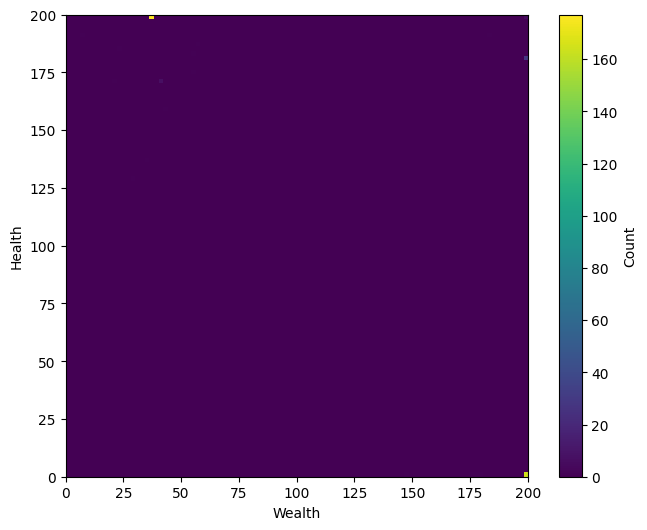

In [729]:
results = []
for i in np.linspace(0,199,20):
    for j in np.linspace(0,199,20):
        init = [i,j]
        minimizer_kwargs = { "method": "L-BFGS-B", "bounds":((0,200),(0,200))}
        R = basinhopping(func, init, minimizer_kwargs=minimizer_kwargs, stepsize=50)
        results.append(tuple(R.x.round(2)))

res_arr = np.array(results)
hist, xedges, yedges = np.histogram2d(res_arr[:,0], res_arr[:,1], range=[(0,200), (0,200)], bins=100)
plt.figure(figsize=(8, 6))
plt.imshow(hist.T, origin='lower', cmap='viridis', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar(label='Count')
plt.xlabel('Wealth')
plt.ylabel('Health')
plt.show()

In [731]:
Counter(results)

Counter({(np.float64(37.68), np.float64(200.0)): 168,
         (np.float64(200.0), np.float64(0.0)): 148,
         (np.float64(200.0), np.float64(180.18)): 24,
         (np.float64(40.34), np.float64(170.76)): 7,
         (np.float64(200.0), np.float64(200.0)): 6,
         (np.float64(199.94), np.float64(0.0)): 2,
         (np.float64(199.0), np.float64(0.0)): 2,
         (np.float64(199.84), np.float64(180.18)): 1,
         (np.float64(29.22), np.float64(128.24)): 1,
         (np.float64(7.6), np.float64(190.25)): 1,
         (np.float64(54.56), np.float64(182.26)): 1,
         (np.float64(199.08), np.float64(0.0)): 1,
         (np.float64(199.3), np.float64(0.0)): 1,
         (np.float64(174.54), np.float64(0.0)): 1,
         (np.float64(37.68), np.float64(199.0)): 1,
         (np.float64(199.63), np.float64(0.0)): 1,
         (np.float64(23.82), np.float64(184.47)): 1,
         (np.float64(200.0), np.float64(148.29)): 1,
         (np.float64(37.68), np.float64(199.72)): 1,
         

### minimize

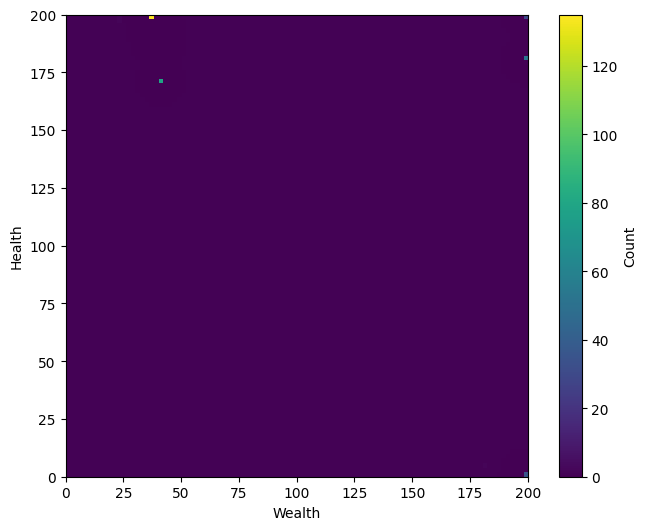

In [732]:
results = []
for i in np.linspace(0,199,100):
    for j in np.linspace(0,199,100):
        init = [i,j]
        R = minimize(func, init, method="L-BFGS-B", bounds=((0,200),(0,200)))
        results.append(tuple(R.x.round(2)))

res_arr = np.array(results)
hist, xedges, yedges = np.histogram2d(res_arr[:,0], res_arr[:,1], range=[(0,200), (0,200)], bins=100)
plt.figure(figsize=(8, 6))
plt.imshow(hist.T, origin='lower', cmap='viridis', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar(label='Count')
plt.xlabel('Wealth')
plt.ylabel('Health')
plt.show()

In [733]:
Counter(results)

Counter({(np.float64(37.68), np.float64(200.0)): 106,
         (np.float64(40.34), np.float64(170.76)): 79,
         (np.float64(200.0), np.float64(180.18)): 24,
         (np.float64(200.0), np.float64(0.0)): 16,
         (np.float64(37.68), np.float64(199.0)): 12,
         (np.float64(199.0), np.float64(180.18)): 10,
         (np.float64(199.0), np.float64(0.0)): 9,
         (np.float64(200.0), np.float64(200.0)): 8,
         (np.float64(200.0), np.float64(199.0)): 5,
         (np.float64(199.0), np.float64(200.0)): 5,
         (np.float64(199.25), np.float64(180.18)): 2,
         (np.float64(199.6), np.float64(0.0)): 2,
         (np.float64(0.0), np.float64(0.0)): 1,
         (np.float64(0.0), np.float64(2.01)): 1,
         (np.float64(0.0), np.float64(4.02)): 1,
         (np.float64(0.0), np.float64(6.03)): 1,
         (np.float64(0.0), np.float64(8.04)): 1,
         (np.float64(0.0), np.float64(10.05)): 1,
         (np.float64(0.0), np.float64(12.06)): 1,
         (np.float64(0.0),

## Agent decisiosn / repeating sequences

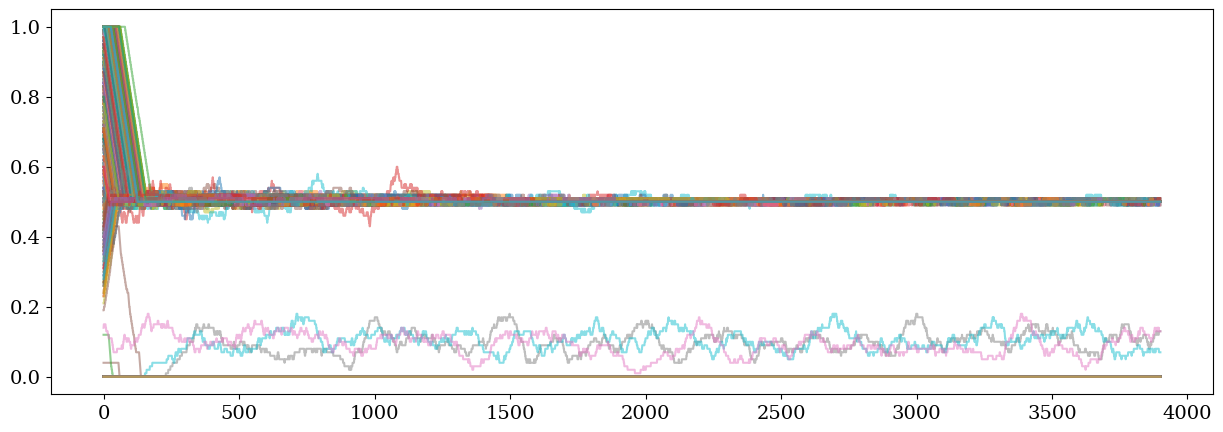

In [54]:
adjusted_wealth = wealth - 1
adjusted_health = health - 1
indices = np.stack([adjusted_wealth, adjusted_health], axis=-1)
decisions = res["policy"][indices[..., 0], indices[..., 1]]

rolling_means = np.array([
    np.convolve(decisions[a], np.ones(100)/100, mode='valid') 
    for a in range(decisions.shape[0])
])

plt.figure(figsize=(15, 5))
plt.plot(rolling_means.T[:,:1000], alpha=0.5)
plt.show()

In [55]:
zero_sequence = []
alt_sequence =  []
one_sequence =  []

L = 50
alt10 = np.tile([1, 0], L // 2 + 1)[:L]
alt01 = np.tile([0, 1], L // 2 + 1)[:L]

# Iterate over each agent
for agent in tqdm(range(decisions.shape[0])):
    d = decisions[agent, :]  # Extract decision array for the agent

    # Compute the cumulative sum for the current agent
    cumsum = np.cumsum(d)

    for i in range(len(d) - L + 1):
        # Compute the sum of the window [i:i+L]
        sum_L = cumsum[i + L - 1] - (cumsum[i - 1] if i > 0 else 0)

        # Check for sequences of L zeros (sum = 0) or L ones (sum = L)
        if sum_L == 0:
            zero_sequence.append(agent)
            break

        if sum_L == L:
            one_sequence.append(agent)
            break

        # Check for alternating sequences
        if np.array_equal(d[i:i+L], alt10) or np.array_equal(d[i:i+L], alt01):
            alt_sequence.append(agent)
            break

  0%|          | 0/10000 [00:00<?, ?it/s]

In [56]:
len(zero_sequence), len(one_sequence), len(alt_sequence)

(3300, 4390, 2309)

In [57]:
len(zero_sequence) + len(one_sequence) + len(alt_sequence)

9999

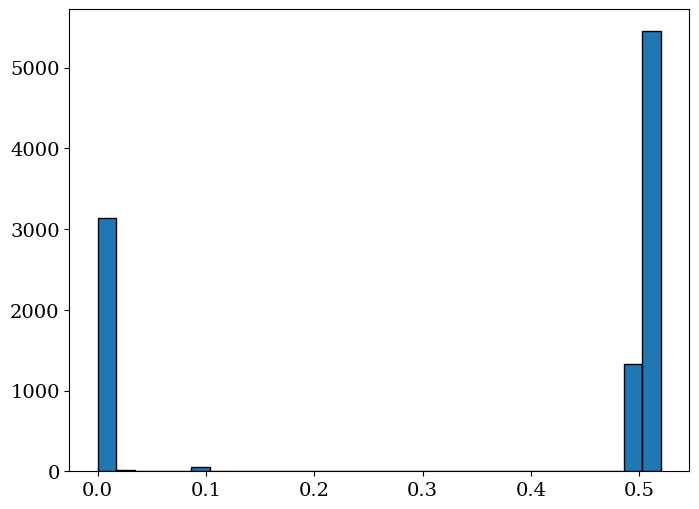

In [58]:
plt.hist(np.mean(decisions, axis=1), bins=30, edgecolor="k")
plt.show()

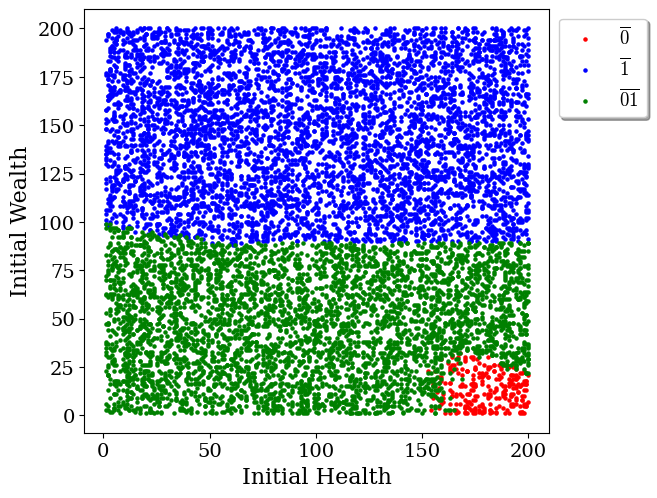

In [50]:
plt.figure(figsize=(6,5.5))
plt.scatter(health[np.array(zero_sequence), 0], wealth[np.array(zero_sequence), 0], c="r", s=5, label=r"$\overline{0}$")
plt.scatter(health[np.array(one_sequence), 0], wealth[np.array(one_sequence), 0], c="b", s=5, label=r"$\overline{1}$")
plt.scatter(health[np.array(alt_sequence), 0], wealth[np.array(alt_sequence), 0], c="g", s=5, label=r"$\overline{01}$")

plt.legend(bbox_to_anchor=(1,1), shadow=True)
plt.xlabel("Initial Health")
plt.ylabel("Initial Wealth")
plt.show()

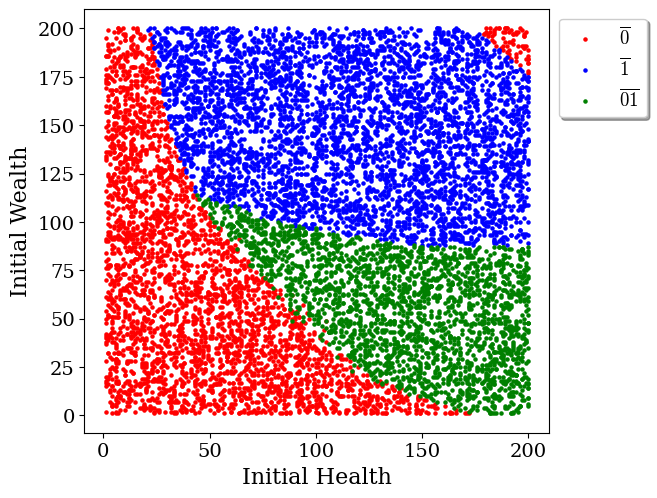

In [59]:
plt.figure(figsize=(6,5.5))
plt.scatter(health[np.array(zero_sequence), 0], wealth[np.array(zero_sequence), 0], c="r", s=5, label=r"$\overline{0}$")
plt.scatter(health[np.array(one_sequence), 0], wealth[np.array(one_sequence), 0], c="b", s=5, label=r"$\overline{1}$")
plt.scatter(health[np.array(alt_sequence), 0], wealth[np.array(alt_sequence), 0], c="g", s=5, label=r"$\overline{01}$")

plt.legend(bbox_to_anchor=(1,1), shadow=True)
plt.xlabel("Initial Health")
plt.ylabel("Initial Wealth")
plt.show()